# Summary

Solve for a time-invariant or "steady-state" profile.

This is achieved by first integrating Hamilton's equations along an erosion ray trajectory initiated at a constant velocity "normal fault" boundary. Copies of this ray are then placed at uniformly spaced (vertically downwards) intervals along the boundary, generating a staggered time-sequence of rays whose ensemble positions at an appropriately chosen time slice constitute a time-invariant profile.

Visualization of the ray ensemble is carried out, along with graphing of properties of the time-invariant profile across the model domain. Comparison is made with the "steady-state" profile derived by integrating the model erosion equation directly (via a polynomial in $\mathrm{d}z/\mathrm{d}x$).

### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv10']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, Matrix, Eq, Rational
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
from gme.ode_raytracing import TimeInvariantSolution
from gme.plot import TimeInvariantPlots, ManuscriptPlots

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv10'])

In [2]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
pr.job.group_name = 'Schematics'
pr.job.short_name = 'sch'
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Schematics',
    'short_name': 'sch',
    'subtitle': '',
    'title': 'Time-invariant profile solution: ramp, eta=3/2, sin(beta) model',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 3/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 3/4,
    't_xiv0_list': None,
    'varepsilon': 1/100,
    'varphi_0': 300,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 10}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': False,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'Radau', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.035,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 30,
    'spline_order': 3,
    't_isochrone_max': 0.01,
    'tolerance': None}
{   'ang_x_limits': [

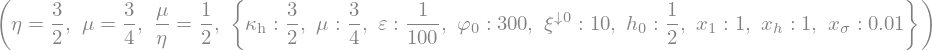

In [3]:
# Create a dict of the key physics parameters to be used in substitutions
# pr.model.varepsilon = 0
sub = {x_1: pr.model.x_1, 
       mu: pr.model.mu,
       varepsilon: pr.model.varepsilon, 
       varphi_0: pr.model.varphi_0,
       xiv_0: pr.model.xiv_0,
       kappa_h: pr.model.kappa_h,
       h_0: pr.model.h_0,
       x_sigma: pr.model.x_sigma,
       x_h: pr.model.x_h}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

Derive the GME equation set (using Sympy) for a specific erosion model.

In [4]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=True )

# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=0} = (0,0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$.

Create an instance of the ODE solution object.

In [5]:
gmes = TimeInvariantSolution( gmeq, parameters=sub, 
                              t_end=pr.solve.t_end, t_distribn=pr.solve.t_distribn, xf_stop=0.999,
                              n_t=pr.solve.ray_n_t,
                              choice=pr.solve.choice, 
                              method=pr.solve.method[pr.solve.choice],
                              do_dense=pr.solve.do_dense )

Solve Hamilton's ODEs using Radau method of integration


Set of initial conditions for the ray.

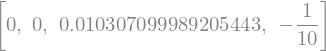

In [6]:
gmes.initial_conditions()

Perform integration of the coupled ODEs.

In [7]:
gmes.solve()
print('Message: {}\nSuccess? {}\nStatus: {}\nt_final: {}\nrx_final: {}'
      .format(gmes.solns[0].message, gmes.solns[0].success,
              gmes.solns[0].status, gmes.solns[0].t[-1], gmes.solns[0].y[0][-1]) )

Message: A termination event occurred.
Success? True
Status: 1
t_final: 0.03293150000000001
rx_final: 0.9984184882315376


Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [8]:
gmes.postprocessing(spline_order=pr.resolve.spline_order)
gmes.more_postprocessing(spline_order=pr.resolve.spline_order)

Generate a time-invariant profile by spatially integrating the topographic gradients implied by the time series of front normal slownesses  $\{\mathbf{\widetilde{p}}\}$. 

This profile can alternatively be generated by synthesizing a staggered sequence of rays and gathering all the ray positions $\{\mathbf{r}\}$ for a chosen time slice. This has already been done in the post-processing step.

In [9]:
gmes.integrate_h_profile(do_truncate=True)

# Plots

Visualization of results

## Preliminaries

In [10]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
suffix += f'_ratio{float(sy.N(gmeq.mu/gmeq.eta))}' if gmeq.mu!=Rational(1,2) else ''
suffix += f'_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
            else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix
job_name

'sch_sinbeta_ramp_eta1p5_ratio0p5_xiv10'

## Schematics

Generate explanatory figures for publication 

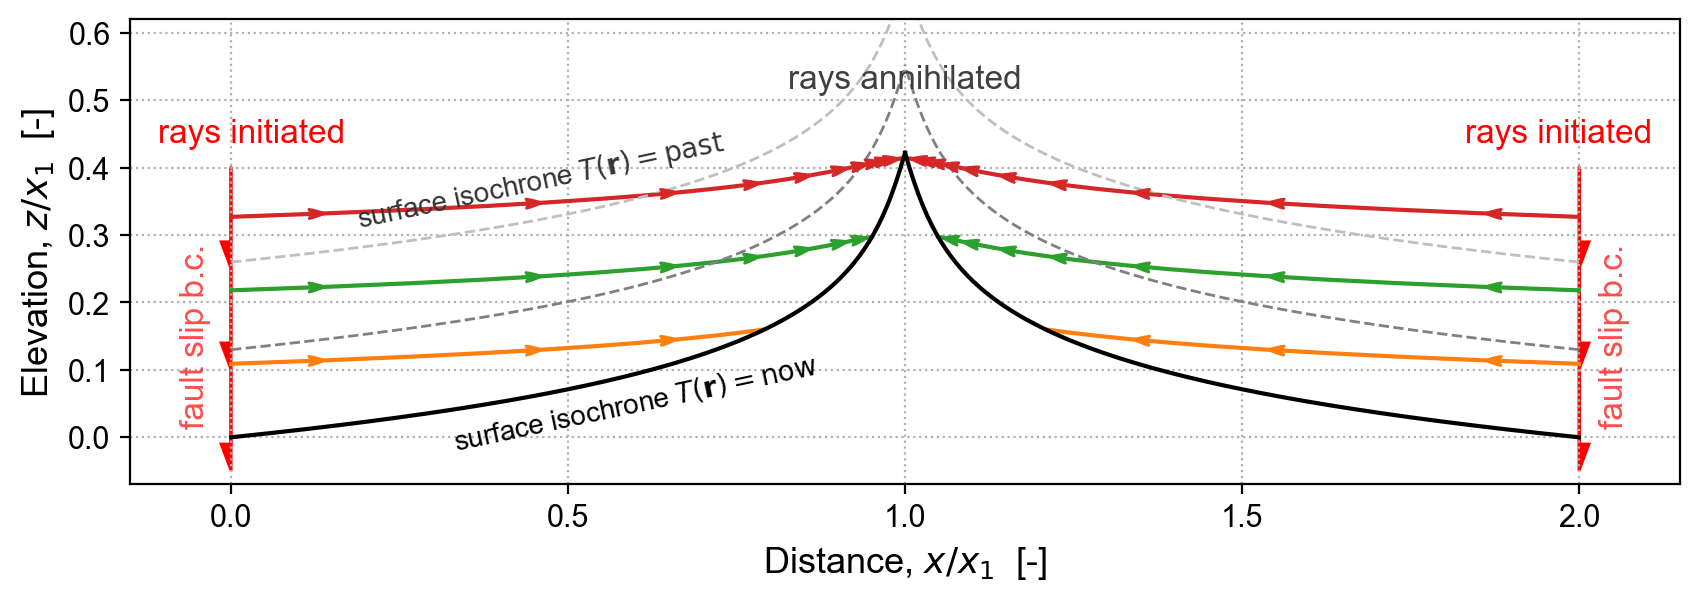

In [11]:
gr1 = TimeInvariantPlots()
gr1.profile_h_rays( gmes, gmeq, sub, job_name+'_tis_cross_section', fig_size=(10,7), n_points=31,
                    ray_subsetting=pr.plot.ray_subsetting//2, do_direct=True, do_schematic=True )

In [12]:
gr2 = ManuscriptPlots()

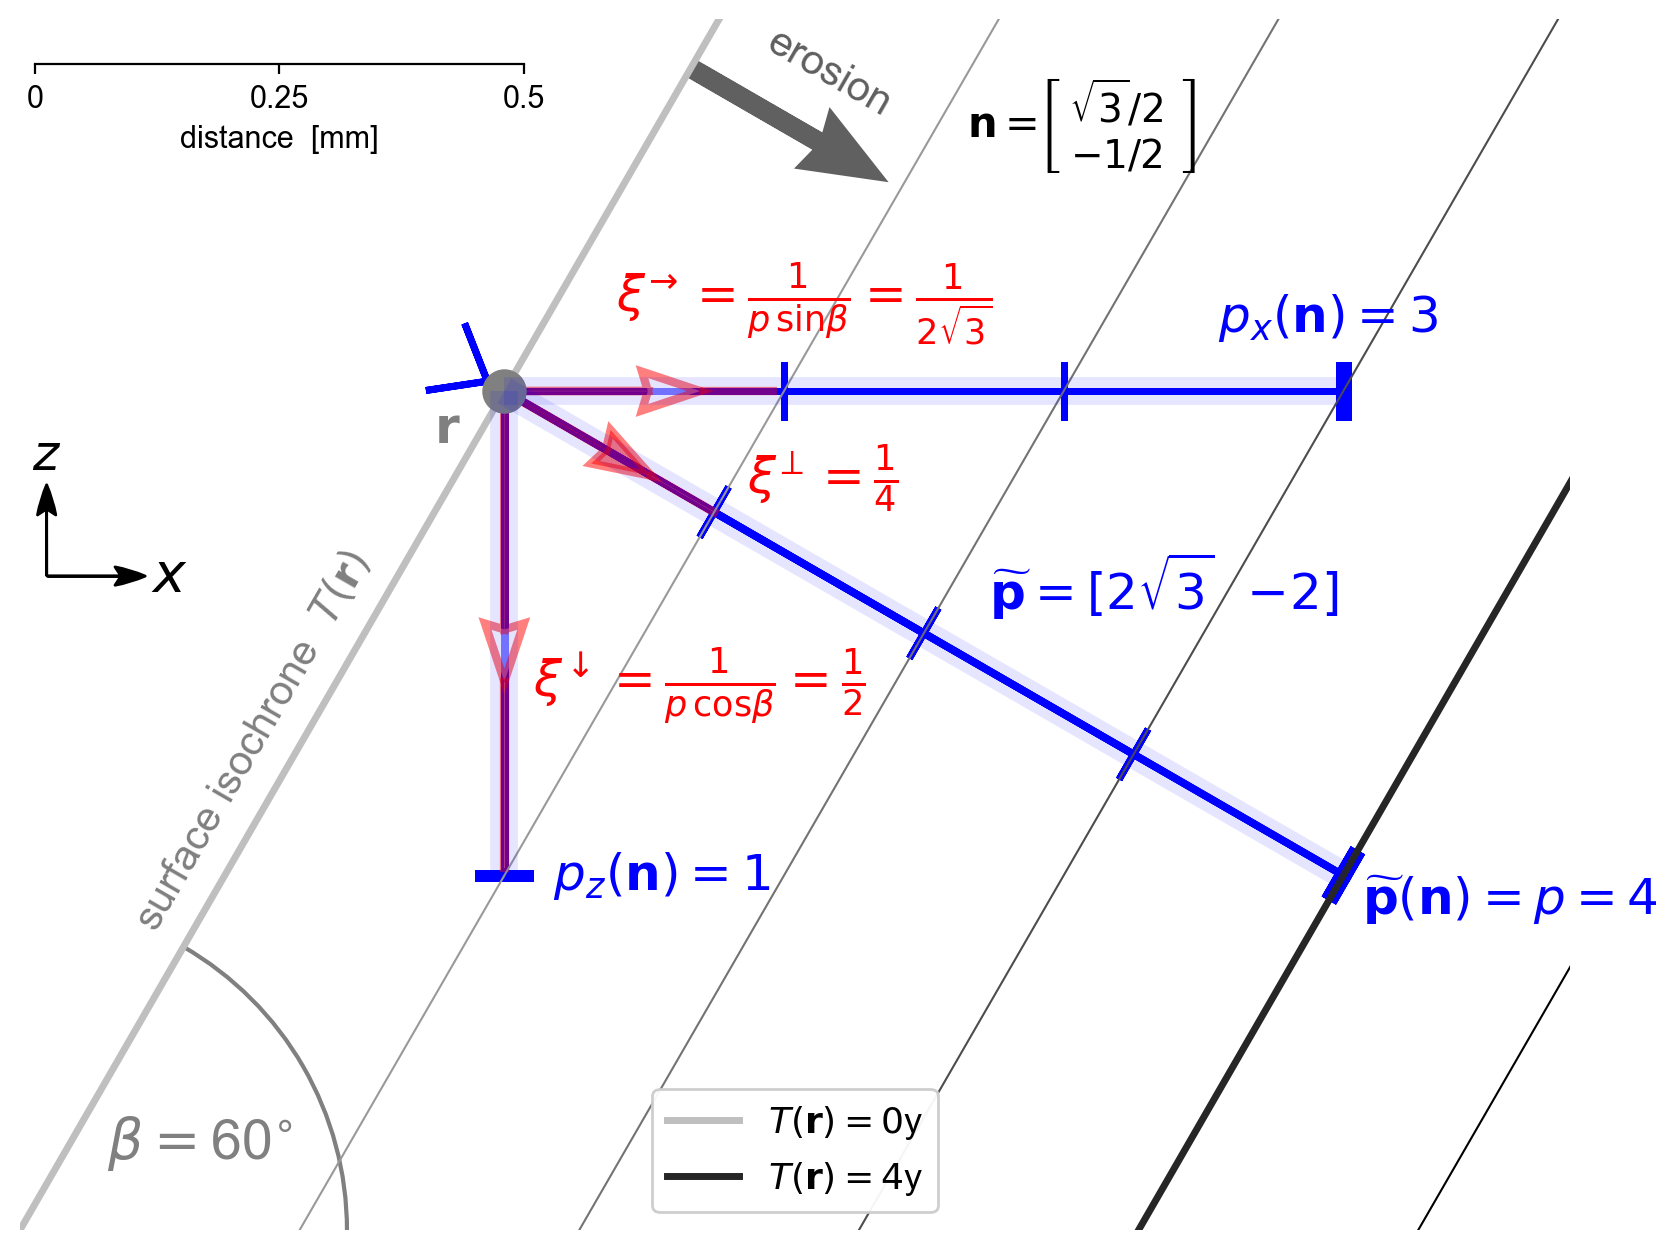

In [13]:
gr2.covector_isochrones(name='sch_covector_isochrones', fig_size=(10,10))

0: 111


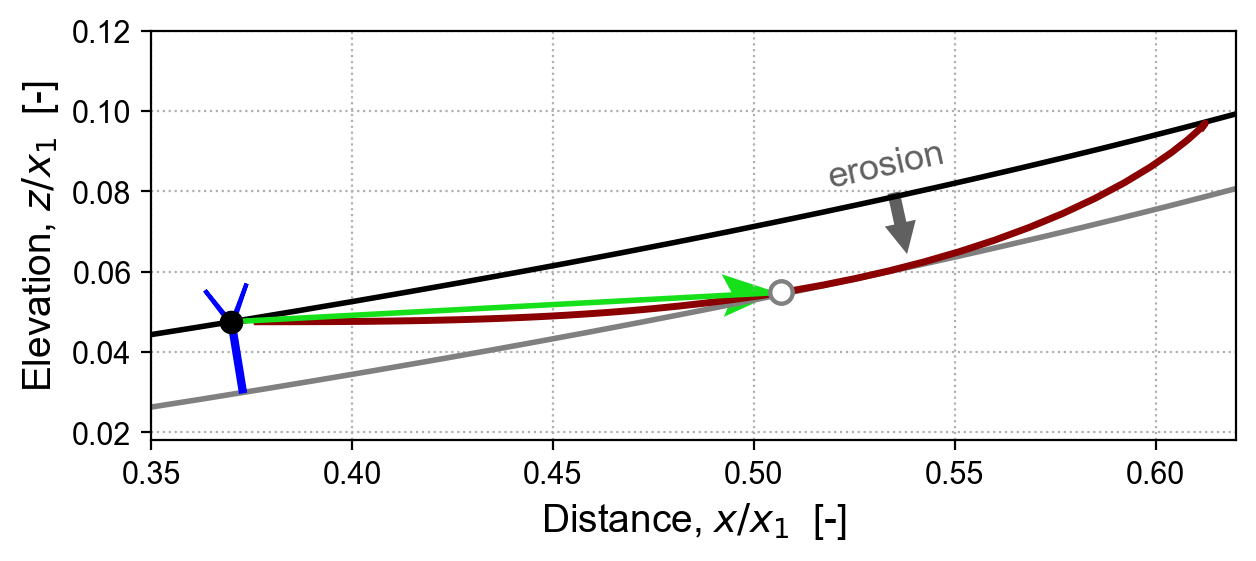

In [14]:
gr2.huygens_wavelets( gmes, gmeq, sub, job_name+'_ray_conjugacy', fig_size=(7,6),
                      do_ray_conjugacy=True, do_legend=False, annotation_fontsize=13 )

0: 111


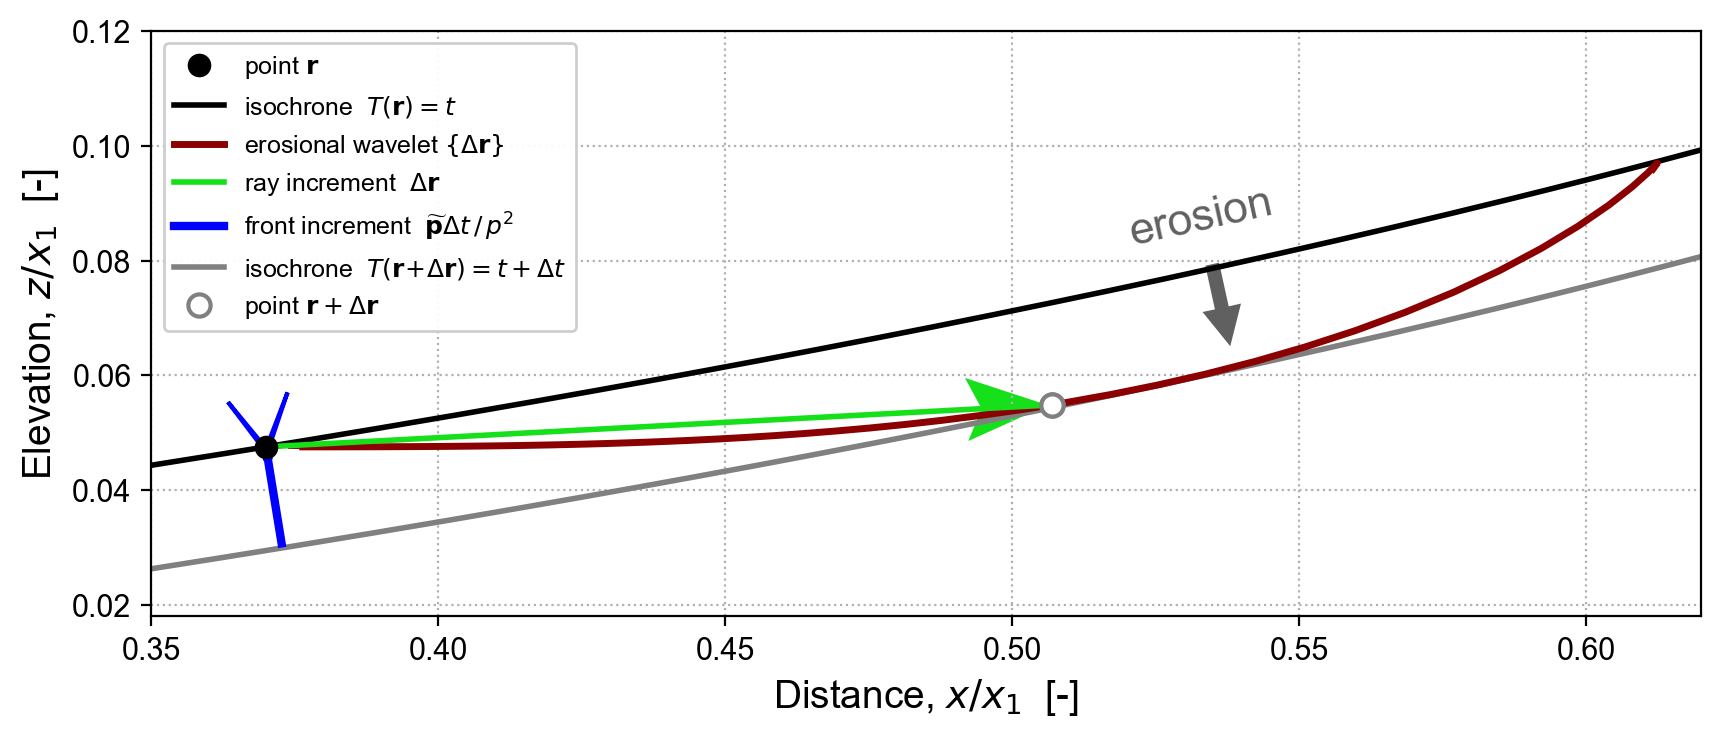

In [15]:
gr2.huygens_wavelets( gmes, gmeq, sub, job_name+'_ray_conjugacy_legend', fig_size=(10,6),
                      do_ray_conjugacy=True, do_legend=True, legend_fontsize=9,
                      annotation_fontsize=16 )

0: 0
1: 34
2: 56
3: 74
4: 91
5: 107
6: 121
7: 135
8: 148
9: 161
10: 173
11: 185
12: 197
13: 208
14: 220


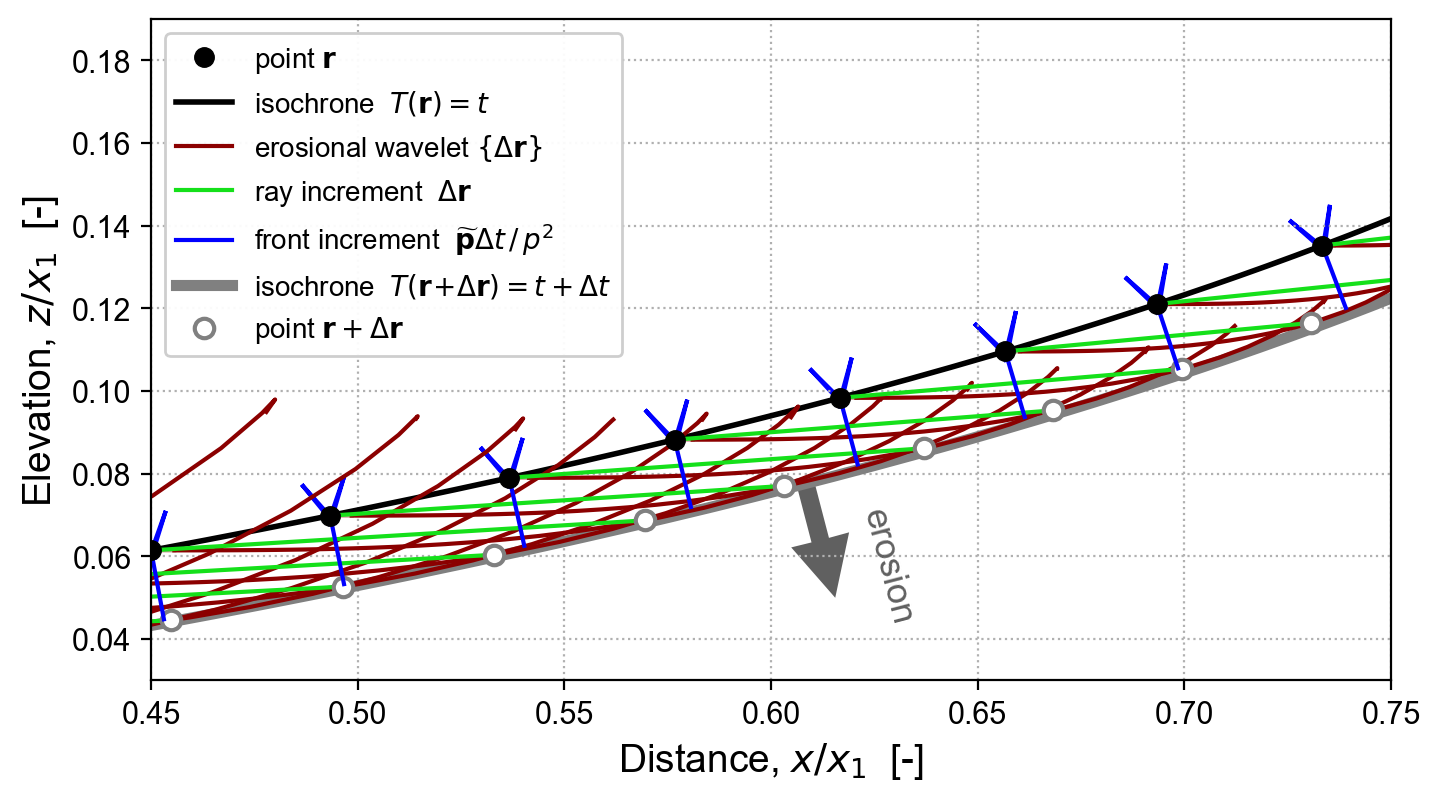

In [16]:
gr2.huygens_wavelets( gmes, gmeq, sub, job_name+'_huygens_wavelets', fig_size=(8,6),
                      do_legend=True, annotation_fontsize=13 )

In [17]:
# gr.profile_flow_model( gmes, gmeq, sub, job_name+'_flow_model', fig_size=(5,4),
#                        subtitle=pr.job.subtitle, n_points=51,
#                        do_extra_annotations=pr.plot.do_extra_annotations )

In [18]:
# gr.profile_slope_area( gmes, gmeq, sub, job_name+'_slope_area', fig_size=(5,4),
#                        subtitle=pr.job.subtitle, n_points=51,
#                        do_extra_annotations=pr.plot.do_extra_annotations,
#                        do_simple=not pr.plot.do_ray_conjugacy );

In [19]:
# gr.profile_h_rays( gmes, gmeq, sub, job_name+'_schematic', fig_size=(10,7), n_points=31,
#                    ray_subsetting=pr.plot.ray_subsetting//2, do_direct=True, do_schematic=True )

In [20]:
# if pr.plot.do_profile_extra:
#     gr.profile_h_rays( gmes, gmeq, sub, job_name+'_h_rays_extra', fig_size=(10,7), 
#                        ray_subsetting=pr.plot.ray_subsetting, n_points=pr.plot.rays_n_points,
#                        do_simple=True )

# Save

Export the graphs as PNG and/or PDF image files.

In [21]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
[export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' ) for gr in [gr1, gr2]];

Writing to dir: "/Users/colinstark/Projects/GME/Plots/Schematics"
Exported "sch_sinbeta_ramp_eta1p5_ratio0p5_xiv10_tis_cross_section.png"
Writing to dir: "/Users/colinstark/Projects/GME/Plots/Schematics"
Exported "sch_covector_isochrones.png"
Exported "sch_sinbeta_ramp_eta1p5_ratio0p5_xiv10_ray_conjugacy.png"
Exported "sch_sinbeta_ramp_eta1p5_ratio0p5_xiv10_ray_conjugacy_legend.png"
Exported "sch_sinbeta_ramp_eta1p5_ratio0p5_xiv10_huygens_wavelets.png"
